In [4]:
import numpy as np
import pandas as pd
import geopandas as gpd
import contextily as cx

from shapely.geometry import Point, MultiPoint, LineString, Polygon
from pathlib import Path

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
DATA_PATH = Path("../site-master/source/notebooks/L4/data")

In [5]:
hel = gpd.read_file(
    DATA_PATH / "Helsinki_borders.shp"
)
grid = gpd.read_file(
    DATA_PATH / "TravelTimes_to_5975375_RailwayStation.shp"
)

In [6]:
hel.head()

,GML_ID,NAMEFIN,NAMESWE,NATCODE,geometry
0,27517366,Helsinki,Helsingfors,091,"POLYGON ((399936.363 6684600.244, 399937.630 6..."


In [7]:
grid.head()

,car_m_d,car_m_t,car_r_d,car_r_t,from_id,pt_m_d,pt_m_t,pt_m_tt,pt_r_d,pt_r_t,pt_r_tt,to_id,walk_d,walk_t,geometry
0,32297,43,32260,48,5785640,32616,116,147,32616,108,139,5975375,32164,459,"POLYGON ((382000.000 6697750.000, 381750.000 6..."
1,32508,43,32471,49,5785641,32822,119,145,32822,111,133,5975375,29547,422,"POLYGON ((382250.000 6697750.000, 382000.000 6..."
2,30133,50,31872,56,5785642,32940,121,146,32940,113,133,5975375,29626,423,"POLYGON ((382500.000 6697750.000, 382250.000 6..."
3,32690,54,34429,60,5785643,33233,125,150,33233,117,144,5975375,29919,427,"POLYGON ((382750.000 6697750.000, 382500.000 6..."
4,31872,42,31834,48,5787544,32127,109,126,32127,101,121,5975375,31674,452,"POLYGON ((381250.000 6697500.000, 381000.000 6..."


## Overlay data

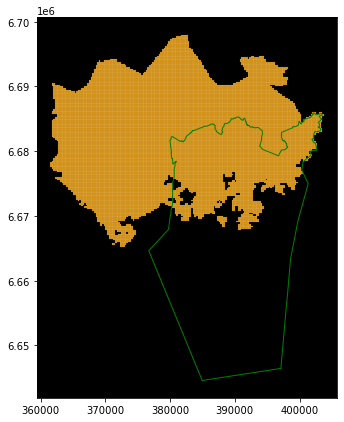

In [13]:
_, ax = plt.subplots(figsize=(7, 7))
grid.plot(
    ax=ax,
    facecolor="orange",
    edgecolor="white",
    linewidth=0.1,
    alpha=0.8
)
hel.plot(
    ax=ax,
    facecolor="None",
    edgecolor="green",
    alpha=1
)
ax.set_facecolor("k")

In [15]:
hel.crs

<Derived Projected CRS: EPSG:3067>
Name: ETRS89 / TM35FIN(E,N)
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Finland - onshore and offshore.
- bounds: (19.08, 58.84, 31.59, 70.09)
Coordinate Operation:
- name: TM35FIN
- method: Transverse Mercator
Datum: European Terrestrial Reference System 1989 ensemble
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [16]:
grid.crs

<Derived Projected CRS: EPSG:3067>
Name: ETRS89 / TM35FIN(E,N)
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Finland - onshore and offshore.
- bounds: (19.08, 58.84, 31.59, 70.09)
Coordinate Operation:
- name: TM35FIN
- method: Transverse Mercator
Datum: European Terrestrial Reference System 1989 ensemble
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [17]:
# Find intersection of the two areas
intersection = gpd.overlay(
    grid, 
    hel,
    how="intersection"
)

<AxesSubplot:>

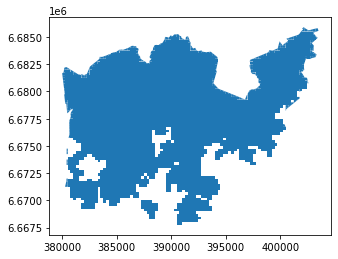

In [19]:
intersection.plot()

In [22]:
intersection2 = (grid
                 .loc[grid.intersects(hel.at[0, "geometry"])]
                )

<AxesSubplot:>

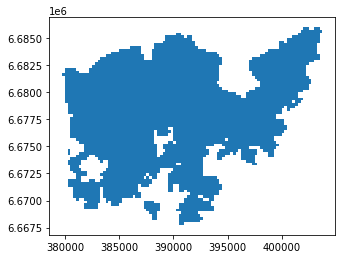

In [23]:
intersection2.plot()

This second approach does not clip the cells at the border.

In [25]:
intersection.head()

,car_m_d,car_m_t,car_r_d,car_r_t,from_id,pt_m_d,pt_m_t,pt_m_tt,pt_r_d,pt_r_t,pt_r_tt,to_id,walk_d,walk_t,GML_ID,NAMEFIN,NAMESWE,NATCODE,geometry
0,29476,41,29483,46,5876274,29990,76,95,24984,77,99,5975375,25532,365,27517366,Helsinki,Helsingfors,091,"POLYGON ((402024.224 6685750.000, 402003.328 6..."
1,29456,41,29462,46,5876275,29866,74,95,24860,75,93,5975375,25408,363,27517366,Helsinki,Helsingfors,091,"POLYGON ((402250.000 6685750.000, 402250.000 6..."
2,36772,50,36778,56,5876278,33541,116,137,44265,130,146,5975375,31110,444,27517366,Helsinki,Helsingfors,091,"POLYGON ((403148.515 6685750.000, 403243.781 6..."
3,36898,49,36904,56,5876279,33720,119,141,44444,132,155,5975375,31289,447,27517366,Helsinki,Helsingfors,091,"POLYGON ((403250.000 6685750.000, 403250.000 6..."
4,29411,40,29418,44,5878128,29944,75,95,24938,76,99,5975375,25486,364,27517366,Helsinki,Helsingfors,091,"POLYGON ((401900.425 6685500.000, 402000.000 6..."


In [27]:
intersection.to_file((DATA_PATH 
                      / "TravelTimes_to_5975375_RailwayStation_Helsinki.geojson"),
                      driver="GeoJSON"
                     )

## Aggregating data

In [30]:
time_aggregate = (intersection
                  .dissolve(
                      by="car_r_t",
                      aggfunc="first"
                  )
                  .reset_index()
                 )

In [31]:
time_aggregate.head()

,car_r_t,geometry,car_m_d,car_m_t,car_r_d,from_id,pt_m_d,pt_m_t,pt_m_tt,pt_r_d,pt_r_t,pt_r_tt,to_id,walk_d,walk_t,GML_ID,NAMEFIN,NAMESWE,NATCODE
0,-1,"MULTIPOLYGON (((384750.000 6670000.000, 384500...",-1,-1,-1,5913094,-1,-1,-1,-1,-1,-1,-1,-1,-1,27517366,Helsinki,Helsingfors,091
1,0,"POLYGON ((385750.000 6672000.000, 385750.000 6...",0,0,0,5975375,0,0,0,0,0,0,5975375,0,0,27517366,Helsinki,Helsingfors,091
2,7,"POLYGON ((386250.000 6671750.000, 386000.000 6...",1051,7,1051,5973739,617,5,6,617,5,6,5975375,448,6,27517366,Helsinki,Helsingfors,091
3,8,"MULTIPOLYGON (((386000.000 6671500.000, 385750...",1286,8,1286,5973736,706,10,10,706,10,10,5975375,706,10,27517366,Helsinki,Helsingfors,091
4,9,"MULTIPOLYGON (((385000.000 6671250.000, 385000...",1871,9,1871,5970457,1384,11,13,1394,11,12,5975375,1249,18,27517366,Helsinki,Helsingfors,091


<AxesSubplot:>

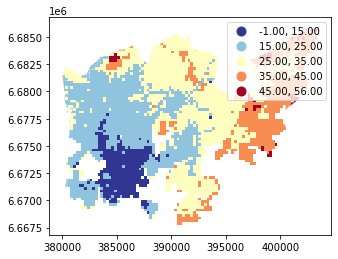

In [32]:
time_aggregate.plot(
    column="car_r_t",
    scheme="quantiles",
    cmap="RdYlBu_r",
    legend=True
)

## Simplifying geometries

In [34]:
ama = gpd.read_file(
    DATA_PATH / "Amazon_river.shp"
)

In [35]:
ama.crs

<Derived Projected CRS: PROJCS["Mercator_2SP",GEOGCS["GCS_GRS 1980(IUGG, 1 ...>
Name: Mercator_2SP
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Mercator (variant B)
Datum: D_unknown
- Ellipsoid: GRS80
- Prime Meridian: Unknown

<AxesSubplot:>

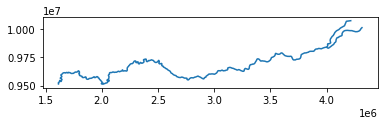

In [36]:
ama.plot()

In [37]:
ama.head()

,bbox_east,bbox_north,bbox_south,bbox_west,place_name,geometry
0,-49.10927,0.70653,-4.44219,-73.450126,"Rio Amazonas, Microrregião de Manaus, Mesorreg...","MULTILINESTRING ((1612358.589 9508606.173, 161..."


In [38]:
ama = (ama
       .assign(
           geom_gen=lambda x:x.simplify(tolerance=20000)
       )
       .set_geometry("geom_gen")
      )

<AxesSubplot:>

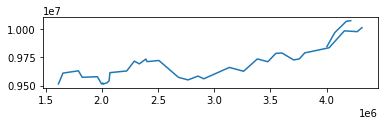

In [39]:
ama.plot()

## Case study

In [43]:
import json
from pyproj import CRS
import requests
import geojson

In [91]:
url = "http://geo.stat.fi/geoserver/tilastointialueet/wfs"

params = dict(service='WFS', 
              version='2.0.0', 
              request='GetFeature', 
              typeName='tilastointialueet:kunta1000k', 
              outputFormat='json')

req = requests.get(url, params=params)
geodata = (gpd.GeoDataFrame.from_features(geojson.loads(req.content))
           .set_crs(epsg=3067)
           .rename(
               columns={"kunta": "code"}
           )
           [["code", "name", "geometry"]]
      )

In [89]:
geodata.head()

,code,name,geometry
0,005,Alajärvi,"POLYGON ((366787.924 7001300.583, 364150.540 7..."
1,009,Alavieska,"POLYGON ((382543.364 7120022.976, 380556.177 7..."
2,010,Alavus,"POLYGON ((343298.204 6961570.195, 340572.015 6..."
3,016,Asikkala,"POLYGON ((436139.680 6798279.085, 432732.949 6..."
4,018,Askola,"POLYGON ((426631.036 6720528.076, 425751.505 6..."


In [92]:
geodata.crs

<Derived Projected CRS: EPSG:3067>
Name: ETRS89 / TM35FIN(E,N)
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Finland - onshore and offshore.
- bounds: (19.08, 58.84, 31.59, 70.09)
Coordinate Operation:
- name: TM35FIN
- method: Transverse Mercator
Datum: European Terrestrial Reference System 1989 ensemble
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

<AxesSubplot:>

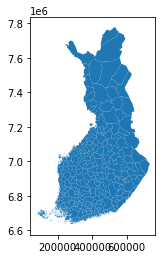

In [93]:
geodata.plot()

In [94]:
health_distr = pd.read_excel(
    DATA_PATH / r"Shp_jäsenkunnat_2020.xls",
    sheet_name="kunnat_shp_2020_ aakkosjärj.",
    header=3
)

In [95]:
health_distr.head()

,kunta-\nkoodi,kunta,shp:n koodi,sairaanhoitopiiri,erva-alue,kuntien lkm
0,NaN,NaN,NaN,NaN,NaN,NaN
1,20.0,Akaa,6.0,Pirkanmaa,TAYS,1.0
2,5.0,Alajärvi,15.0,Etelä-Pohjanmaa,TAYS,2.0
3,9.0,Alavieska,18.0,Pohjois-Pohjanmaa,OYS,3.0
4,10.0,Alavus,15.0,Etelä-Pohjanmaa,TAYS,4.0


In [97]:
health_distr = (health_distr
                .dropna(how="all")
               )

In [98]:
health_distr = (health_distr
                .rename(
                    columns={"kunta-\nkoodi":"code", 
                             'sairaanhoitopiiri':'healthcare_distr'}
                )
                [["code", "healthcare_distr"]]
               )

In [99]:
health_distr.head()

,code,healthcare_distr
1,20.0,Pirkanmaa
2,5.0,Etelä-Pohjanmaa
3,9.0,Pohjois-Pohjanmaa
4,10.0,Etelä-Pohjanmaa
5,16.0,Päijät-Häme


In [100]:
health_distr = (health_distr
                .assign(
                    code=lambda x:(x["code"]
                                   .astype(int)
                                   .astype(str)
                                   .str
                                   .zfill(3))
                )
               )

In [101]:
health_distr.head()

,code,healthcare_distr
1,020,Pirkanmaa
2,005,Etelä-Pohjanmaa
3,009,Pohjois-Pohjanmaa
4,010,Etelä-Pohjanmaa
5,016,Päijät-Häme


In [102]:
geodata.head()

,code,name,geometry
0,005,Alajärvi,"POLYGON ((366787.924 7001300.583, 364150.540 7..."
1,009,Alavieska,"POLYGON ((382543.364 7120022.976, 380556.177 7..."
2,010,Alavus,"POLYGON ((343298.204 6961570.195, 340572.015 6..."
3,016,Asikkala,"POLYGON ((436139.680 6798279.085, 432732.949 6..."
4,018,Askola,"POLYGON ((426631.036 6720528.076, 425751.505 6..."


In [103]:
mun_hospitals = geodata.merge(health_distr,
                              how="left",
                              on="code"
                             )

In [104]:
mun_hospitals = (mun_hospitals
                 .assign(
                     healthcare_distr=lambda x:x["healthcare_distr"].where(
                         x["healthcare_distr"].notnull(),
                         "Ahvenanmaa")
                 )
                )

In [105]:
mun_hospitals["healthcare_distr"].value_counts()

Pohjois-Pohjanmaa    29
Varsinais-Suomi      28
HUS                  24
Pirkanmaa            23
Keski-Suomi          21
Etelä-Pohjanmaa      18
Pohjois-Savo         18
Ahvenanmaa           16
Satakunta            16
Lappi                15
Vaasa                13
Pohjois-Karjala      13
Päijät-Häme          12
Kanta-Häme           11
Keski-Pohjanmaa      10
Etelä-Savo            9
Etelä-Karjala         9
Kainuu                8
Kymenlaakso           6
Länsi-Pohja           6
Itä-Savo              4
Name: healthcare_distr, dtype: int64

In [107]:
healthcare_distr = (mun_hospitals
                    .dissolve(
                        by="healthcare_distr"
                    )
                    .reset_index()
                    [["healthcare_distr", "geometry"]]
                   )

<AxesSubplot:>

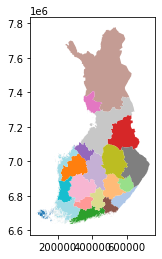

In [108]:
healthcare_distr.plot(
    column="healthcare_distr",
    cmap="tab20",
)

In [109]:
healthcare_distr.crs

<Derived Projected CRS: EPSG:3067>
Name: ETRS89 / TM35FIN(E,N)
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Finland - onshore and offshore.
- bounds: (19.08, 58.84, 31.59, 70.09)
Coordinate Operation:
- name: TM35FIN
- method: Transverse Mercator
Datum: European Terrestrial Reference System 1989 ensemble
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [110]:
healthcare_distr.to_file(
    DATA_PATH / "health_districts_EPSG3067.geojson",
    driver="GeoJSON",
    encoding="utf-8"
)

In [111]:
(healthcare_distr
 .to_crs(epsg=4326)
 .to_file(
     DATA_PATH / "health_districts_EPSG4326.geojson",
     driver="GeoJSON",
     encoding="utf-8"
 )
)

## Data classification

In [123]:
times = (gpd.read_file(
    DATA_PATH / "TravelTimes_to_5975375_RailwayStation_Helsinki.geojson")
         .replace(-1, np.nan)
        )

In [124]:
times.head()

,car_m_d,car_m_t,car_r_d,car_r_t,from_id,pt_m_d,pt_m_t,pt_m_tt,pt_r_d,pt_r_t,pt_r_tt,to_id,walk_d,walk_t,GML_ID,NAMEFIN,NAMESWE,NATCODE,geometry
0,29476.0,41.0,29483.0,46.0,5876274,29990.0,76.0,95.0,24984.0,77.0,99.0,5975375.0,25532.0,365.0,27517366,Helsinki,Helsingfors,091,"POLYGON ((402024.224 6685750.000, 402003.328 6..."
1,29456.0,41.0,29462.0,46.0,5876275,29866.0,74.0,95.0,24860.0,75.0,93.0,5975375.0,25408.0,363.0,27517366,Helsinki,Helsingfors,091,"POLYGON ((402250.000 6685750.000, 402250.000 6..."
2,36772.0,50.0,36778.0,56.0,5876278,33541.0,116.0,137.0,44265.0,130.0,146.0,5975375.0,31110.0,444.0,27517366,Helsinki,Helsingfors,091,"POLYGON ((403148.515 6685750.000, 403243.781 6..."
3,36898.0,49.0,36904.0,56.0,5876279,33720.0,119.0,141.0,44444.0,132.0,155.0,5975375.0,31289.0,447.0,27517366,Helsinki,Helsingfors,091,"POLYGON ((403250.000 6685750.000, 403250.000 6..."
4,29411.0,40.0,29418.0,44.0,5878128,29944.0,75.0,95.0,24938.0,76.0,99.0,5975375.0,25486.0,364.0,27517366,Helsinki,Helsingfors,091,"POLYGON ((401900.425 6685500.000, 402000.000 6..."


In [126]:
times.isnull().sum()

car_m_d     12
car_m_t     12
car_r_d     12
car_r_t     12
from_id      0
pt_m_d      19
pt_m_t      19
pt_m_tt     19
pt_r_d      19
pt_r_t      19
pt_r_tt     19
to_id       12
walk_d      46
walk_t      46
GML_ID       0
NAMEFIN      0
NAMESWE      0
NATCODE      0
geometry     0
dtype: int64

In [127]:
times = (times
         .dropna(
             subset=["pt_r_tt"]
         )
        )

<AxesSubplot:>

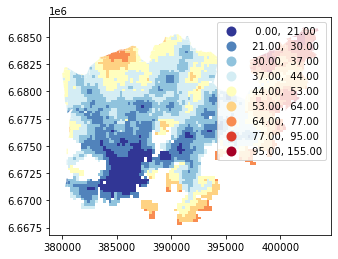

In [128]:
times.plot(
    column="pt_r_tt",
    scheme="Fisher_Jenks",
    k=9,
    cmap="RdYlBu_r",
    legend=True
)

<AxesSubplot:>

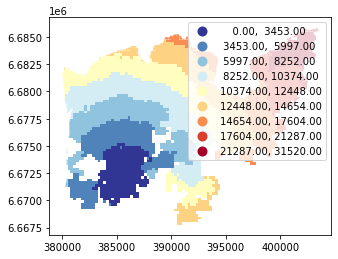

In [130]:
times.plot(
    column="walk_d",
    scheme="Fisher_jenks",
    k=9,
    cmap="RdYlBu_r",
    legend=True
)

In [131]:
import mapclassify

In [132]:
classifier = mapclassify.NaturalBreaks.make(k=9)

In [137]:
times = (times
         .assign(
             time_dist_class=lambda x:x[["pt_r_tt"]].apply(classifier)
         )
        )

In [138]:
times.head()

,car_m_d,car_m_t,car_r_d,car_r_t,from_id,pt_m_d,pt_m_t,pt_m_tt,pt_r_d,pt_r_t,pt_r_tt,to_id,walk_d,walk_t,GML_ID,NAMEFIN,NAMESWE,NATCODE,geometry,time_dist_class
0,29476.0,41.0,29483.0,46.0,5876274,29990.0,76.0,95.0,24984.0,77.0,99.0,5975375.0,25532.0,365.0,27517366,Helsinki,Helsingfors,091,"POLYGON ((402024.224 6685750.000, 402003.328 6...",8
1,29456.0,41.0,29462.0,46.0,5876275,29866.0,74.0,95.0,24860.0,75.0,93.0,5975375.0,25408.0,363.0,27517366,Helsinki,Helsingfors,091,"POLYGON ((402250.000 6685750.000, 402250.000 6...",7
2,36772.0,50.0,36778.0,56.0,5876278,33541.0,116.0,137.0,44265.0,130.0,146.0,5975375.0,31110.0,444.0,27517366,Helsinki,Helsingfors,091,"POLYGON ((403148.515 6685750.000, 403243.781 6...",8
3,36898.0,49.0,36904.0,56.0,5876279,33720.0,119.0,141.0,44444.0,132.0,155.0,5975375.0,31289.0,447.0,27517366,Helsinki,Helsingfors,091,"POLYGON ((403250.000 6685750.000, 403250.000 6...",8
4,29411.0,40.0,29418.0,44.0,5878128,29944.0,75.0,95.0,24938.0,76.0,99.0,5975375.0,25486.0,364.0,27517366,Helsinki,Helsingfors,091,"POLYGON ((401900.425 6685500.000, 402000.000 6...",8


## Histograms

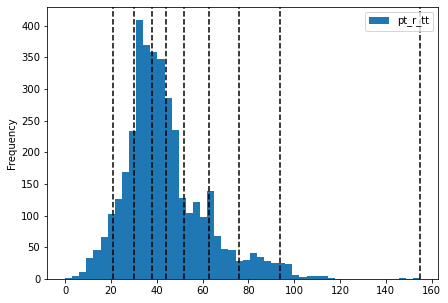

In [148]:
_, ax = plt.subplots(figsize=(7, 5))
(times
 .plot(
     ax=ax,
     y="pt_r_tt",
     kind="hist",
     bins=50
 )
)
classifier = mapclassify.NaturalBreaks(y=times["pt_r_tt"],
                                       k=9
                                       )
for edge in classifier.bins:
    plt.axvline(edge,
                color="k",
                linestyle="--",
                linewidth=1.5
               )

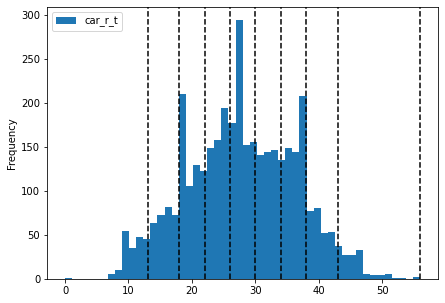

In [149]:
# car travel times
_, ax = plt.subplots(figsize=(7, 5))
(times
 .plot(
     ax=ax,
     kind="hist",
     y="car_r_t",
     bins=50
 )
)
classifier = mapclassify.FisherJenks(
    y=times["car_r_t"],
    k=9
)
for edge in classifier.bins:
    ax.axvline(edge,
               color="k",
               linestyle="--",
               linewidth=1.5
              )

<AxesSubplot:>

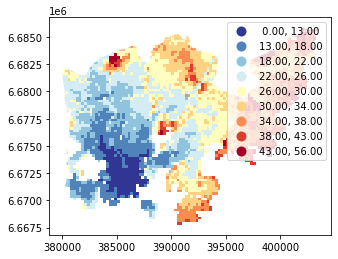

In [147]:
times.plot(
    column="car_r_t",
    scheme="Fisher_Jenks",
    cmap="RdYlBu_r",
    k=9,
    legend=True
)

## Exercises

In [167]:
DATA_PATH = Path(r"../data/exercise-4")

### 1

#### Import data

In [175]:
grid = (gpd.read_file(DATA_PATH / "MetropAccess_YKR_grid_EurefFIN.shp")
        .rename(
            columns={"YKR_ID": "from_id"}
        )
       )

In [176]:
grid.crs

<Derived Projected CRS: EPSG:3067>
Name: ETRS89 / TM35FIN(E,N)
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Finland - onshore and offshore.
- bounds: (19.08, 58.84, 31.59, 70.09)
Coordinate Operation:
- name: TM35FIN
- method: Transverse Mercator
Datum: European Terrestrial Reference System 1989 ensemble
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [153]:
grid.head()

,x,y,YKR_ID,geometry
0,381875.0,6697880.0,5785640,"POLYGON ((382000.000 6697750.000, 381750.000 6..."
1,382125.0,6697880.0,5785641,"POLYGON ((382250.000 6697750.000, 382000.000 6..."
2,382375.0,6697880.0,5785642,"POLYGON ((382500.000 6697750.000, 382250.000 6..."
3,382625.0,6697880.0,5785643,"POLYGON ((382750.000 6697750.000, 382500.000 6..."
4,381125.0,6697630.0,5787544,"POLYGON ((381250.000 6697500.000, 381000.000 6..."


<AxesSubplot:>

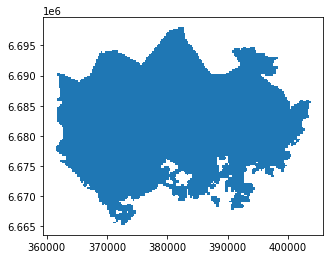

In [154]:
grid.plot()

In [369]:
class DataLoader():
    def __init__(self, mall_name, columns):
        self.mall_name = mall_name
        self.cols = columns
        self.data = (pd.read_csv(DATA_PATH / f"TravelTimes_to_{mall_name}.txt", sep=";", na_values=-1)
                     [columns]
                    )
    
    def merge_geo_info(self, geo_df):
        self.data = (geo_df
                     [["from_id", "geometry"]]
                     .merge(self.data, on="from_id", how="right")
                    )
        return self
        
    def dropna(self):
        self.data = (self.data
                     .dropna(how="any")
                    )
        return self
        
    def classify_times(self, time_cols, bins):
        classifier = mapclassify.UserDefined.make(bins=bins)
        for time in time_cols:
            self.data[f"{time}_cl"] = self.data[[time]].apply(classifier)
        return self
            
    def plot_travel_times(self, time_cols):
        _, axes = plt.subplots(1, 2, figsize=(14, 5))
        axes = axes.ravel()
        for i, time in enumerate(time_cols):
            self.data.plot(
                ax=axes[i],
                column=f"{time}_cl",
                cmap="RdYlBu_r",
                legend=True
            )
            axes[i].set_title(f"{self.mall_name.split('_')[1]} - Travel times by {time.split('_')[0]}",
                              fontsize=16
                             )
            axes[i].axis("off")
        plt.tight_layout()

In [370]:
columns = ["pt_r_t", "car_r_t", "from_id", "to_id"]
time_cols = ["pt_r_t", "car_r_t"]
bins = np.arange(5, 61, 5)

In [371]:
itis = DataLoader("5944003_Itis", columns)

In [372]:
itis.data.head()

,pt_r_t,car_r_t,from_id,to_id
0,132.0,50.0,5785640,5944003.0
1,135.0,51.0,5785641,5944003.0
2,137.0,58.0,5785642,5944003.0
3,141.0,57.0,5785643,5944003.0
4,125.0,50.0,5787544,5944003.0


In [373]:
itis.merge_geo_info(grid)

In [374]:
itis.data.isnull().sum()

from_id       0
geometry      0
pt_r_t      211
car_r_t      91
to_id        91
dtype: int64

In [375]:
itis.dropna()

In [376]:
itis.data.isnull().sum()

from_id     0
geometry    0
pt_r_t      0
car_r_t     0
to_id       0
dtype: int64

In [377]:
itis.classify_times(["pt_r_t", "car_r_t"], bins)

In [378]:
itis.data.head()

,from_id,geometry,pt_r_t,car_r_t,to_id,pt_r_t_cl,car_r_t_cl
0,5785640,"POLYGON ((382000.000 6697750.000, 381750.000 6...",132.0,50.0,5944003.0,12,9
1,5785641,"POLYGON ((382250.000 6697750.000, 382000.000 6...",135.0,51.0,5944003.0,12,10
2,5785642,"POLYGON ((382500.000 6697750.000, 382250.000 6...",137.0,58.0,5944003.0,12,11
3,5785643,"POLYGON ((382750.000 6697750.000, 382500.000 6...",141.0,57.0,5944003.0,12,11
4,5787544,"POLYGON ((381250.000 6697500.000, 381000.000 6...",125.0,50.0,5944003.0,12,9


In [379]:
itis.data["pt_r_t_cl"].value_counts()

12    6643
10    1055
11    1010
9      977
7      814
8      768
6      664
5      478
4      321
3      200
2       76
1       13
0        1
Name: pt_r_t_cl, dtype: int64

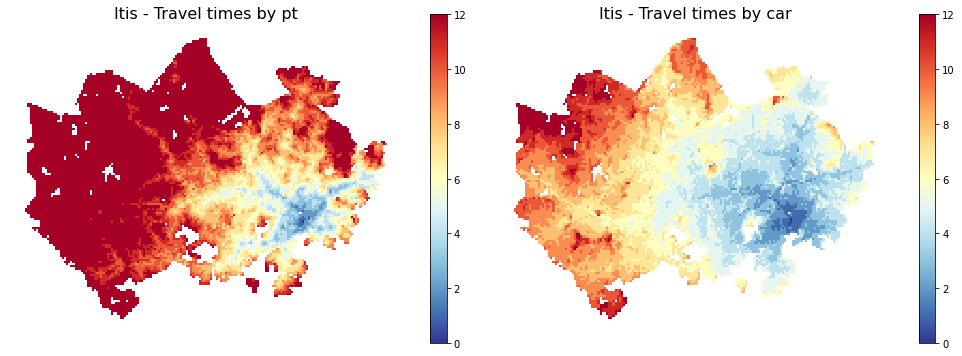

In [380]:
itis.plot_travel_times(time_cols)

In [381]:
myyrmanni = DataLoader("5902043_Myyrmanni", columns)

In [382]:
(myyrmanni
 .merge_geo_info(grid)
 .dropna()
 .classify_times(["pt_r_t", "car_r_t"], bins)
)

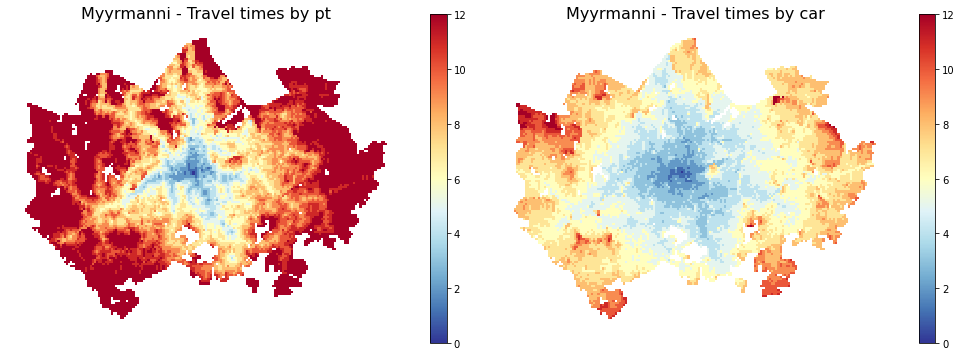

In [383]:
myyrmanni.plot_travel_times(time_cols)

### 2

In [384]:
import os

In [387]:
traveltimes_files = [file for file in os.listdir(DATA_PATH) if "TravelTimes" in file]

In [388]:
traveltimes_files

['TravelTimes_to_5878070_Jumbo.txt',
 'TravelTimes_to_5878087_Dixi.txt',
 'TravelTimes_to_5902043_Myyrmanni.txt',
 'TravelTimes_to_5944003_Itis.txt',
 'TravelTimes_to_5975373_Forum.txt',
 'TravelTimes_to_5978593_IsoOmena.txt',
 'TravelTimes_to_5980260_Ruoholahti.txt']

In [433]:
grid = (gpd.read_file(DATA_PATH / "MetropAccess_YKR_grid_EurefFIN.shp")
        .rename(
            columns={"YKR_ID": "from_id"}
        )
       )

In [435]:
columns = ["pt_r_t", "car_r_t", "from_id"]
for file in traveltimes_files:
    temp_time = (pd.read_csv(DATA_PATH / file, sep=";", na_values=-1)
                 [columns]
                 .rename(
                     columns={
                         "pt_r_t": f"pt_r_t_{file.split('_')[-1][:-4]}",
                         "car_r_t": f"car_r_t_{file.split('_')[-1][:-4]}",
                     }
                 )
                 .dropna(how="any")
                )
    grid = pd.merge(grid, temp_time, on="from_id", how="left")
    

In [436]:
grid.head()

,x,y,from_id,geometry,pt_r_t_Jumbo,car_r_t_Jumbo,pt_r_t_Dixi,car_r_t_Dixi,pt_r_t_Myyrmanni,car_r_t_Myyrmanni,pt_r_t_Itis,car_r_t_Itis,pt_r_t_Forum,car_r_t_Forum,pt_r_t_IsoOmena,car_r_t_IsoOmena,pt_r_t_Ruoholahti,car_r_t_Ruoholahti
0,381875.0,6697880.0,5785640,"POLYGON ((382000.000 6697750.000, 381750.000 6...",101.0,39.0,102.0,45.0,90.0,39.0,132.0,50.0,110.0,49.0,141.0,56.0,118.0,56.0
1,382125.0,6697880.0,5785641,"POLYGON ((382250.000 6697750.000, 382000.000 6...",108.0,39.0,109.0,45.0,93.0,39.0,135.0,51.0,113.0,49.0,143.0,56.0,121.0,56.0
2,382375.0,6697880.0,5785642,"POLYGON ((382500.000 6697750.000, 382250.000 6...",109.0,45.0,111.0,52.0,95.0,47.0,137.0,58.0,115.0,57.0,145.0,64.0,123.0,63.0
3,382625.0,6697880.0,5785643,"POLYGON ((382750.000 6697750.000, 382500.000 6...",114.0,46.0,115.0,48.0,99.0,51.0,141.0,57.0,119.0,60.0,149.0,67.0,127.0,67.0
4,381125.0,6697630.0,5787544,"POLYGON ((381250.000 6697500.000, 381000.000 6...",98.0,38.0,99.0,44.0,83.0,38.0,125.0,50.0,103.0,48.0,134.0,55.0,111.0,55.0


In [437]:
def get_mall_name(df, col_type):
    col_names = [col for col in df.columns if col_type in col]
    min_col_idx = df[col_names].idxmin(axis=1).str.split("_", expand=True)
    return min_col_idx.iloc[:, -1]

In [438]:
grid.isnull().sum()

x                       0
y                       0
from_id                 0
geometry                0
pt_r_t_Jumbo          211
car_r_t_Jumbo         211
pt_r_t_Dixi           211
car_r_t_Dixi          211
pt_r_t_Myyrmanni      211
car_r_t_Myyrmanni     211
pt_r_t_Itis           211
car_r_t_Itis          211
pt_r_t_Forum          211
car_r_t_Forum         211
pt_r_t_IsoOmena       211
car_r_t_IsoOmena      211
pt_r_t_Ruoholahti     211
car_r_t_Ruoholahti    211
dtype: int64

In [431]:
get_mall_name(grid, "car")

0           Jumbo
1           Jumbo
2           Jumbo
3           Jumbo
4           Jumbo
           ...   
13226    IsoOmena
13227    IsoOmena
13228         NaN
13229    IsoOmena
13230    IsoOmena
Name: 3, Length: 13231, dtype: object

In [443]:
mall_dominance = (grid
                  .dropna(how="any")
                  .assign(
                      shortest_car = lambda x:x[[col for col in x.columns if "car" in col]].min(axis=1),
                      shortest_car_mall = lambda x:get_mall_name(x, "car"),
                      shortest_walk = lambda x:x[[col for col in x.columns if "pt" in col]].min(axis=1),
                      shortest_walk_mall = lambda x:get_mall_name(x, "pt")
                  )
                  [["geometry", "shortest_car", "shortest_car_mall", "shortest_walk", "shortest_walk_mall"]]
                 )

In [444]:
mall_dominance.head()

,geometry,shortest_car,shortest_car_mall,shortest_walk,shortest_walk_mall
0,"POLYGON ((382000.000 6697750.000, 381750.000 6...",39.0,Jumbo,90.0,Myyrmanni
1,"POLYGON ((382250.000 6697750.000, 382000.000 6...",39.0,Jumbo,93.0,Myyrmanni
2,"POLYGON ((382500.000 6697750.000, 382250.000 6...",45.0,Jumbo,95.0,Myyrmanni
3,"POLYGON ((382750.000 6697750.000, 382500.000 6...",46.0,Jumbo,99.0,Myyrmanni
4,"POLYGON ((381250.000 6697500.000, 381000.000 6...",38.0,Jumbo,83.0,Myyrmanni


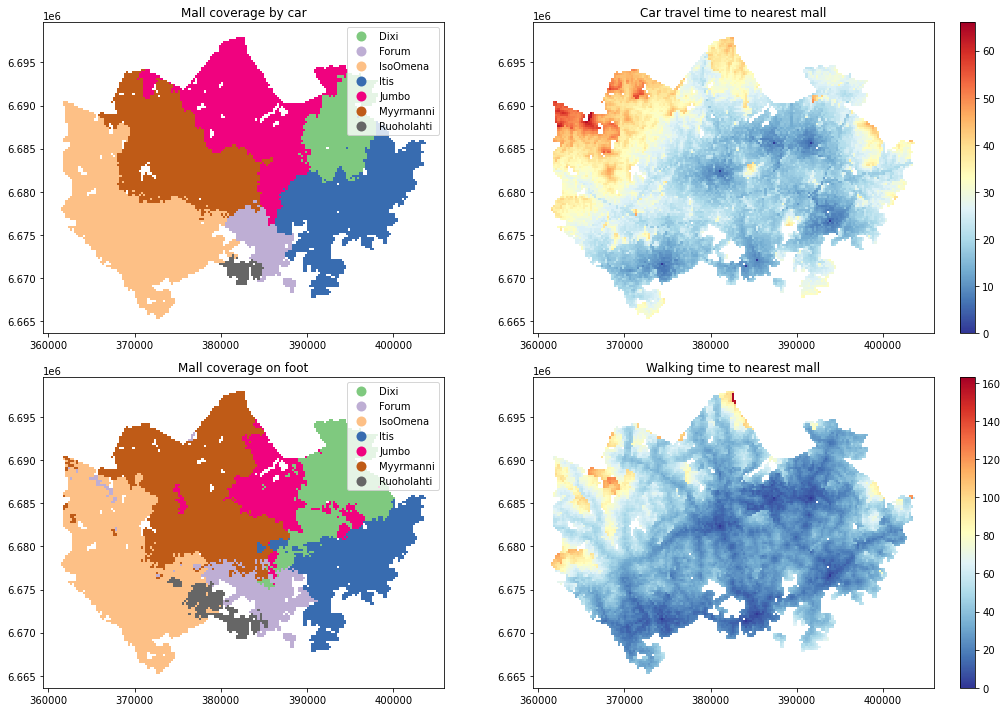

In [454]:
_, axes = plt.subplots(2, 2, figsize=(15, 10))

axes = axes.ravel()
mall_dominance.plot(
    ax=axes[0],
    column="shortest_car_mall",
    cmap="Accent",
    legend=True
)
axes[0].set_title("Mall coverage by car")
mall_dominance.plot(
    ax=axes[1],
    column="shortest_car",
    cmap="RdYlBu_r",
    legend=True
)
axes[1].set_title("Car travel time to nearest mall")
mall_dominance.plot(
    ax=axes[2],
    column="shortest_walk_mall",
    cmap="Accent",
    legend=True
)
axes[2].set_title("Mall coverage on foot")
mall_dominance.plot(
    ax=axes[3],
    column="shortest_walk",
    cmap="RdYlBu_r",
    legend=True
)
axes[3].set_title("Walking time to nearest mall")
plt.tight_layout()

### 3


In [461]:
url = "https://kartta.hsy.fi/geoserver/wfs"

params = dict(service='WFS', 
              version='2.0.0', 
              request='GetFeature', 
              typeName='asuminen_ja_maankaytto:Vaestotietoruudukko_2018', 
              outputFormat='json')

req = requests.get(url, params=params)

pop = (gpd.GeoDataFrame.from_features(geojson.loads(req.content))
       .rename(
           columns={"asukkaita": "population"}
       )
       [["geometry", "population"]]
       .set_crs(epsg=3879)
       .to_crs(epsg=3067)
      )

In [462]:
pop.crs

<Derived Projected CRS: EPSG:3067>
Name: ETRS89 / TM35FIN(E,N)
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Finland - onshore and offshore.
- bounds: (19.08, 58.84, 31.59, 70.09)
Coordinate Operation:
- name: TM35FIN
- method: Transverse Mercator
Datum: European Terrestrial Reference System 1989 ensemble
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [460]:
mall_dominance.crs

<Derived Projected CRS: EPSG:3067>
Name: ETRS89 / TM35FIN(E,N)
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Finland - onshore and offshore.
- bounds: (19.08, 58.84, 31.59, 70.09)
Coordinate Operation:
- name: TM35FIN
- method: Transverse Mercator
Datum: European Terrestrial Reference System 1989 ensemble
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [469]:
mall_dominance_walk = (mall_dominance
                       [["geometry", "shortest_walk", "shortest_walk_mall"]]
                       .dissolve(
                           by="shortest_walk_mall",
                           aggfunc="max"
                       )
                       .reset_index()
                      )

In [470]:
mall_dominance_walk.head()

,shortest_walk_mall,geometry,shortest_walk
0,Dixi,"MULTIPOLYGON (((384500.000 6675750.000, 384250...",96.0
1,Forum,"MULTIPOLYGON (((377750.000 6676750.000, 378000...",107.0
2,IsoOmena,"MULTIPOLYGON (((363250.000 6676750.000, 363000...",126.0
3,Itis,"MULTIPOLYGON (((389750.000 6672500.000, 389750...",124.0
4,Jumbo,"MULTIPOLYGON (((375250.000 6684750.000, 375250...",104.0


In [471]:
mall_dominance_car = (mall_dominance
                      [["geometry", "shortest_car", "shortest_car_mall"]]
                      .dissolve(
                          by="shortest_car_mall",
                          aggfunc="max"
                      )
                      .reset_index()
                     )

In [489]:
type(mall_dominance_walk)

geopandas.geodataframe.GeoDataFrame

In [490]:
type(pop)

geopandas.geodataframe.GeoDataFrame

In [491]:
mall_walk_pop = mall_dominance_walk.sjoin(pop,
                                          predicate="intersects"
                                         )

In [492]:
mall_walk_pop.head()

,shortest_walk_mall,geometry,shortest_walk,index_right,population
0,Dixi,"MULTIPOLYGON (((384500.000 6675750.000, 384250...",96.0,4407,8
3,Itis,"MULTIPOLYGON (((389750.000 6672500.000, 389750...",124.0,4407,8
0,Dixi,"MULTIPOLYGON (((384500.000 6675750.000, 384250...",96.0,3889,525
3,Itis,"MULTIPOLYGON (((389750.000 6672500.000, 389750...",124.0,3889,525
0,Dixi,"MULTIPOLYGON (((384500.000 6675750.000, 384250...",96.0,3853,166


In [493]:
type(mall_walk_pop)

geopandas.geodataframe.GeoDataFrame

In [494]:
mall_walk_pop = (mall_walk_pop
                 .groupby(
                     by="shortest_walk_mall"
                 )
                 .agg(
                     pop_coverage=("population", sum),
                     geometry=("geometry", "first")
                 )
                 .set_geometry("geometry")
                 .reset_index()
                )

In [498]:
mall_walk_pop

,shortest_walk_mall,pop_coverage,geometry
0,Dixi,223770,"MULTIPOLYGON (((384500.000 6675750.000, 384250..."
1,Forum,259697,"MULTIPOLYGON (((377750.000 6676750.000, 378000..."
2,IsoOmena,201205,"MULTIPOLYGON (((363250.000 6676750.000, 363000..."
3,Itis,212502,"MULTIPOLYGON (((389750.000 6672500.000, 389750..."
4,Jumbo,79573,"MULTIPOLYGON (((375250.000 6684750.000, 375250..."
5,Myyrmanni,231630,"MULTIPOLYGON (((368000.000 6681500.000, 368000..."
6,Ruoholahti,87856,"MULTIPOLYGON (((376500.000 6672000.000, 376250..."


<AxesSubplot:>

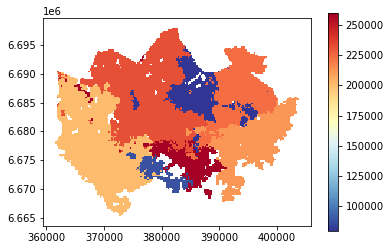

In [497]:
(mall_walk_pop
 .plot(
     column="pop_coverage",
     cmap="RdYlBu_r",
     legend=True
 )
)